In [1]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 1000 #Maximum number of episodes 1000

#DQN Agent for the Cartpole
#Q function approximation with NN, experience replay, and target network
class DQNAgent:
    #Constructor for the agent (invoked when DQN is first called in main)
    def __init__(self, state_size, action_size):
        self.check_solve = True	#If True, stop if you satisfy solution condition
        self.render = True       #If you want to see Cartpole learning, then change to True

        #Get size of state and action
        self.state_size = state_size
        self.action_size = action_size

       # Modify here

        #Set hyper parameters for the DQN. Do not adjust those labeled as Fixed.
        self.discount_factor = 0.995#0.95
        self.learning_rate = 0.005#0.005
        self.epsilon = 0.02 #Fixed
        self.batch_size = 32 #Fixed
        self.memory_size = 7500#1000
        self.train_start = 1000 #Fixed
        self.target_update_frequency = 1#1

        #Number of test states for Q value plots
        self.test_state_no = 10000

        #Create memory buffer using deque
        self.memory = deque(maxlen=self.memory_size)

        #Create main network and target network (using build_model defined below)
        self.model = self.build_model()
        self.target_model = self.build_model()

        #Initialize target network
        self.update_target_model()

    #Approximate Q function using Neural Network
    #State is the input and the Q Values are the output.
###############################################################################
###############################################################################
        #Edit the Neural Network model here
        #Tip: Consult https://keras.io/getting-started/sequential-model-guide/
    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform')) # 16
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
###############################################################################
###############################################################################

    #After some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    #Get action from model using epsilon-greedy policy
    def get_action(self, state):
###############################################################################
###############################################################################
        #Insert your e-greedy policy code here
        #Tip 1: Use the random package to generate a random action.
        #Tip 2: Use keras.model.predict() to compute Q-values from the state.
        
        ''' So E Greedy is like, you take a random action with proabability epsilon, other with 1-e
        
        
        
        '''
        q_val = self.model.predict(state)
        #print("Something is fishy!")
        #print(q_val)
        best_action = np.argmax(q_val);
        #print(" I choose ",best_action)
        rand_act = random.randrange(self.action_size);
        #print(" The random value might be ", rand_act);
        
        
        return np.random.choice([rand_act,best_action],p=[self.epsilon,1-self.epsilon]);

###############################################################################
###############################################################################
    #Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #Add sample to the end of the list

    #Sample <s,a,r,s'> from replay memory
    def train_model(self):
        if len(self.memory) < self.train_start: #Do not train if not enough memory
            return
        batch_size = min(self.batch_size, len(self.memory)) #Train on at most as many samples as you have in memory
        mini_batch = random.sample(self.memory, batch_size) #Uniformly sample the memory buffer
        #Preallocate network and target network input matrices.
        update_input = np.zeros((batch_size, self.state_size)) #batch_size by state_size two-dimensional array (not matrix!)
        update_target = np.zeros((batch_size, self.state_size)) #Same as above, but used for the target network
        action, reward, done = [], [], [] #Empty arrays that will grow dynamically
        y_batch = []#I Created this array

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0] #Allocate s(i) to the network input array from iteration i in the batch
            action.append(mini_batch[i][1]) #Store a(i)
            reward.append(mini_batch[i][2]) #Store r(i)
            update_target[i] = mini_batch[i][3] #Allocate s'(i) for the target network array from iteration i in the batch
            done.append(mini_batch[i][4])  #Store done(i)

        target = self.model.predict(update_input) #Generate target values for training the inner loop network using the network model
        target_val = self.target_model.predict(update_target) #Generate the target values for training the outer loop target network
        #print("Target :",target,"Target_val :",target_val)            
        
       # Added by me 
        y_batch = []
        for i in range(self.batch_size): # Setting yj and gradient descent  line 12-13
        # if terminal only equals reward
            if mini_batch[i][4]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] =  reward[i]+ self.discount_factor * np.max(target_val[i])
            
        #print("Q values in target",target)
        #Q Learning: get maximum Q value at s' from target network
###############################################################################
###########################x####################################################
        #Insert your Q-learning code here
        #Tip 1: Observe that the Q-values are stored in the variable target
        #Tip 2: What is the Q-value of the action taken at the last state of the episode?
        # print(target)
        
        
#         for i in range(self.batch_size): #For every batch
#             if mini_batch[i][4]:
#                target[i][action[i]] = 1
#             target[i][action[i]] += self.learning_rate *(reward[i] + (self.discount_factor * max(target[i]))- target[i][action[i]]) #random.randint(0,1)
# ###############################################################################
###############################################################################

        #Train the inner loop network
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)
        return
    #Plots the score per episode as well as the maximum q value per episode, averaged over precollected states.
    def plot_data(self, episodes, scores, max_q_mean):
        pylab.figure(0)
        pylab.plot(episodes, max_q_mean, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Average Q Value")
        pylab.savefig("qvalues.png")

        pylab.figure(1)
        pylab.plot(episodes, scores, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Score")
        pylab.savefig("scores.png")

###############################################################################
###############################################################################

if __name__ == "__main__":
    #For CartPole-v0, maximum episode length is 200
    env = gym.make('CartPole-v0') #Generate Cartpole-v0 environment object from the gym library
    #Get state and action sizes from the environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    #Create agent, see the DQNAgent __init__ method for details
    agent = DQNAgent(state_size, action_size)

    #Collect test states for plotting Q values using uniform random policy
    test_states = np.zeros((agent.test_state_no, state_size))
    max_q = np.zeros((EPISODES, agent.test_state_no))
    max_q_mean = np.zeros((EPISODES,1))

    done = True
    for i in range(agent.test_state_no):
        if done:
            done = False
            state = env.reset()
            state = np.reshape(state, [1, state_size])
            test_states[i] = state
        else:
            action = random.randrange(action_size)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            test_states[i] = state
            state = next_state

    scores, episodes = [], [] #Create dynamically growing score and episode counters
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset() #Initialize/reset the environment
        state = np.reshape(state, [1, state_size]) #Reshape state so that to a 1 by state_size two-dimensional array ie. [x_1,x_2] to [[x_1,x_2]]
        #Compute Q values for plotting
        tmp = agent.model.predict(test_states)
        max_q[e][:] = np.max(tmp, axis=1)
        max_q_mean[e] = np.mean(max_q[e][:])

        while not done:
            if agent.render:
                env.render() #Show cartpole animation

            #Get action for the current state and go one step in environment
            action = agent.get_action(state) # Selecting the action by epsilon greedy -sab #Line 6 and 7
            next_state, reward, done, info = env.step(action) # Executing the action  - sab # Line 8
            next_state = np.reshape(next_state, [1, state_size]) #Reshape next_state similarly to state # maybe line 9

            #Save sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)  # this looks like the storing transition in D - sab # Line 10
            #Training step
            agent.train_model()
            score += reward #Store episodic reward
            state = next_state #Propagate state

            if done:
                #At the end of very episode, update the target network
                if e % agent.target_update_frequency == 0:
                    agent.update_target_model()
                #Plot the play time for every episode
                scores.append(score)
                episodes.append(e)

                print("episode:", e, "  score:", score," q_value:", max_q_mean[e],"  memory length:",
                      len(agent.memory))

                # if the mean of scores of last 100 episodes is bigger than 195
                # stop training
                if agent.check_solve:
                    if np.mean(scores[-min(100, len(scores)):]) >= 195:
                        print("solved after", e-100, "episodes")
                        agent.plot_data(episodes,scores,max_q_mean[:e+1])
                        sys.exit()
    agent.plot_data(episodes,scores,max_q_mean)

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 13.0  q_value: [

episode: 101   score: 10.0  q_value: [29.51773058]   memory length: 1345
episode: 102   score: 48.0  q_value: [28.86633071]   memory length: 1393
episode: 103   score: 35.0  q_value: [28.77507728]   memory length: 1428
episode: 104   score: 10.0  q_value: [28.98226198]   memory length: 1438
episode: 105   score: 14.0  q_value: [29.19281254]   memory length: 1452
episode: 106   score: 13.0  q_value: [29.65355739]   memory length: 1465
episode: 107   score: 17.0  q_value: [30.05919391]   memory length: 1482
episode: 108   score: 13.0  q_value: [30.09657601]   memory length: 1495
episode: 109   score: 16.0  q_value: [30.1452771]   memory length: 1511
episode: 110   score: 55.0  q_value: [30.63140721]   memory length: 1566
episode: 111   score: 39.0  q_value: [30.47557573]   memory length: 1605
episode: 112   score: 118.0  q_value: [30.97413396]   memory length: 1723
episode: 113   score: 83.0  q_value: [31.93144703]   memory length: 1806
episode: 114   score: 96.0  q_value: [33.40636277] 

episode: 213   score: 200.0  q_value: [96.64780716]   memory length: 7500
episode: 214   score: 200.0  q_value: [96.31918694]   memory length: 7500
episode: 215   score: 200.0  q_value: [95.1321691]   memory length: 7500
episode: 216   score: 200.0  q_value: [95.25266398]   memory length: 7500
episode: 217   score: 200.0  q_value: [95.10990573]   memory length: 7500
episode: 218   score: 200.0  q_value: [95.5418215]   memory length: 7500
episode: 219   score: 200.0  q_value: [95.79922021]   memory length: 7500
episode: 220   score: 200.0  q_value: [97.08853358]   memory length: 7500
episode: 221   score: 200.0  q_value: [97.58403938]   memory length: 7500
episode: 222   score: 200.0  q_value: [97.52701255]   memory length: 7500
episode: 223   score: 200.0  q_value: [98.06494071]   memory length: 7500
episode: 224   score: 200.0  q_value: [98.09635395]   memory length: 7500
episode: 225   score: 200.0  q_value: [98.49879167]   memory length: 7500
episode: 226   score: 200.0  q_value: [9

episode: 323   score: 200.0  q_value: [134.35990304]   memory length: 7500
episode: 324   score: 200.0  q_value: [136.28843231]   memory length: 7500
episode: 325   score: 200.0  q_value: [136.14539638]   memory length: 7500
episode: 326   score: 200.0  q_value: [137.38160471]   memory length: 7500
episode: 327   score: 200.0  q_value: [139.74356582]   memory length: 7500
episode: 328   score: 200.0  q_value: [139.96772615]   memory length: 7500
episode: 329   score: 200.0  q_value: [138.80140252]   memory length: 7500
episode: 330   score: 200.0  q_value: [139.18199512]   memory length: 7500
episode: 331   score: 169.0  q_value: [139.06318427]   memory length: 7500
episode: 332   score: 200.0  q_value: [138.58757959]   memory length: 7500
episode: 333   score: 200.0  q_value: [138.62782157]   memory length: 7500
episode: 334   score: 167.0  q_value: [141.21453006]   memory length: 7500
episode: 335   score: 177.0  q_value: [141.56660105]   memory length: 7500
episode: 336   score: 177

episode: 433   score: 157.0  q_value: [185.18671552]   memory length: 7500
episode: 434   score: 159.0  q_value: [186.27997728]   memory length: 7500
episode: 435   score: 155.0  q_value: [186.96115562]   memory length: 7500
episode: 436   score: 200.0  q_value: [186.44562036]   memory length: 7500
episode: 437   score: 200.0  q_value: [188.19842626]   memory length: 7500
episode: 438   score: 200.0  q_value: [189.75952493]   memory length: 7500
episode: 439   score: 200.0  q_value: [191.54143588]   memory length: 7500
episode: 440   score: 200.0  q_value: [191.98316406]   memory length: 7500
episode: 441   score: 200.0  q_value: [192.65102192]   memory length: 7500
episode: 442   score: 200.0  q_value: [193.40078803]   memory length: 7500
episode: 443   score: 200.0  q_value: [195.1969192]   memory length: 7500
episode: 444   score: 200.0  q_value: [195.84867047]   memory length: 7500
episode: 445   score: 200.0  q_value: [197.49336394]   memory length: 7500
episode: 446   score: 200.

episode: 543   score: 187.0  q_value: [284.271971]   memory length: 7500
episode: 544   score: 185.0  q_value: [283.84111053]   memory length: 7500
episode: 545   score: 196.0  q_value: [283.41869032]   memory length: 7500
episode: 546   score: 200.0  q_value: [283.15798311]   memory length: 7500
episode: 547   score: 200.0  q_value: [281.99300477]   memory length: 7500
episode: 548   score: 182.0  q_value: [279.28869046]   memory length: 7500
episode: 549   score: 200.0  q_value: [278.85015734]   memory length: 7500
episode: 550   score: 200.0  q_value: [279.39235475]   memory length: 7500
episode: 551   score: 200.0  q_value: [280.62603241]   memory length: 7500
episode: 552   score: 187.0  q_value: [279.94089427]   memory length: 7500
episode: 553   score: 163.0  q_value: [280.85548055]   memory length: 7500
episode: 554   score: 172.0  q_value: [280.32701574]   memory length: 7500
episode: 555   score: 200.0  q_value: [280.36160236]   memory length: 7500
episode: 556   score: 200.0

episode: 653   score: 200.0  q_value: [323.47945586]   memory length: 7500
episode: 654   score: 200.0  q_value: [322.27674516]   memory length: 7500
episode: 655   score: 200.0  q_value: [322.18953846]   memory length: 7500
episode: 656   score: 200.0  q_value: [320.53065494]   memory length: 7500
episode: 657   score: 200.0  q_value: [322.00263021]   memory length: 7500
episode: 658   score: 172.0  q_value: [323.38285415]   memory length: 7500
episode: 659   score: 200.0  q_value: [324.0745003]   memory length: 7500
episode: 660   score: 200.0  q_value: [324.35992305]   memory length: 7500
episode: 661   score: 200.0  q_value: [324.30729501]   memory length: 7500
episode: 662   score: 164.0  q_value: [322.26156218]   memory length: 7500
episode: 663   score: 197.0  q_value: [325.24540742]   memory length: 7500
episode: 664   score: 200.0  q_value: [324.24208252]   memory length: 7500
episode: 665   score: 200.0  q_value: [324.09918092]   memory length: 7500
episode: 666   score: 200.

SystemExit: 

/Users/sabarishsridhar/Anaconda3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


ValueError: x and y must have same first dimension, but have shapes (735,) and (1000, 1)

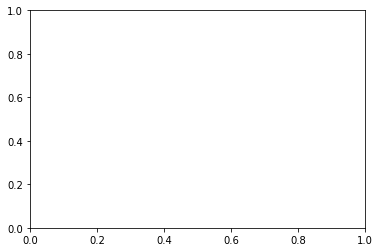

In [2]:
agent.plot_data(episodes,scores,max_q_mean)